In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

os.makedirs('../figures', exist_ok = True)

# Define the relative path to the 'src' folder
module_path = os.path.abspath(os.path.join('..', 'src'))

# Add the path to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)

import analysis_utils as utils

# TODO: DELETE
#print(os.getcwd())

In [3]:
df_od_age_group = pd.read_csv("../data/overdose_age_data_clean.csv")


In [4]:
df_od_age_group.head(5)

,INDICATOR,PANEL,PANEL_NUM,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE,AGE_NUM,ESTIMATE,FLAG,sex,age_group
0,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, crude",2,Sex,2,Male,2.1,2017,19,All ages,1.1,29.0,NaN,Male,All
1,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, crude",2,Total,0,All persons,0.1,2006,8,All ages,1.1,11.5,NaN,All,All
2,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, crude",2,Sex,2,Male,2.1,2016,18,All ages,1.1,26.1,NaN,Male,All
3,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, crude",2,Total,0,All persons,0.1,1999,1,All ages,1.1,6.0,NaN,All,All
4,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, crude",2,Total,0,All persons,0.1,2000,2,All ages,1.1,6.2,NaN,All,All


In [5]:
# filter for all drug overdose deaths
all_od_deaths = df_od_age_group[df_od_age_group["PANEL_NUM"] == 0]
# remove "All from age_group and sex since we want to look at distinct age_groups and distinct sex
all_od_deaths = all_od_deaths[(all_od_deaths["age_group"] != "All") & (all_od_deaths["sex"] != "All")]
all_od_deaths.head(5)

,INDICATOR,PANEL,PANEL_NUM,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE,AGE_NUM,ESTIMATE,FLAG,sex,age_group
228,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Male: Under 15 years,3.11,1999,1,Under 15 years,1.2,0.1,NaN,Male,Under 15 years
229,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Male: Under 15 years,3.11,2000,2,Under 15 years,1.2,0.2,NaN,Male,Under 15 years
230,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Male: Under 15 years,3.11,2001,3,Under 15 years,1.2,0.2,NaN,Male,Under 15 years
231,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Male: Under 15 years,3.11,2002,4,Under 15 years,1.2,0.2,NaN,Male,Under 15 years
232,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Male: Under 15 years,3.11,2003,5,Under 15 years,1.2,0.2,NaN,Male,Under 15 years


In [6]:
# get female and make deaths by year
male_female_ave = all_od_deaths[(all_od_deaths["sex"] == "Female") | (all_od_deaths["sex"] == "Male")].groupby(["YEAR", "sex"]).mean("ESTIMATE").reset_index()

male_female_ave.head(5)

,YEAR,sex,PANEL_NUM,UNIT_NUM,STUB_NAME_NUM,STUB_LABEL_NUM,YEAR_NUM,AGE_NUM,ESTIMATE,FLAG
0,1999,Female,0.0,2.0,3.0,3.25,1.0,1.59,3.833333,NaN
1,1999,Male,0.0,2.0,3.0,3.15,1.0,1.59,7.222222,NaN
2,2000,Female,0.0,2.0,3.0,3.25,2.0,1.59,3.955556,NaN
3,2000,Male,0.0,2.0,3.0,3.15,2.0,1.59,7.433333,NaN
4,2001,Female,0.0,2.0,3.0,3.25,3.0,1.59,4.388889,NaN


✓ Saved: figures/drug_overdose_death_rates_by_sex.png


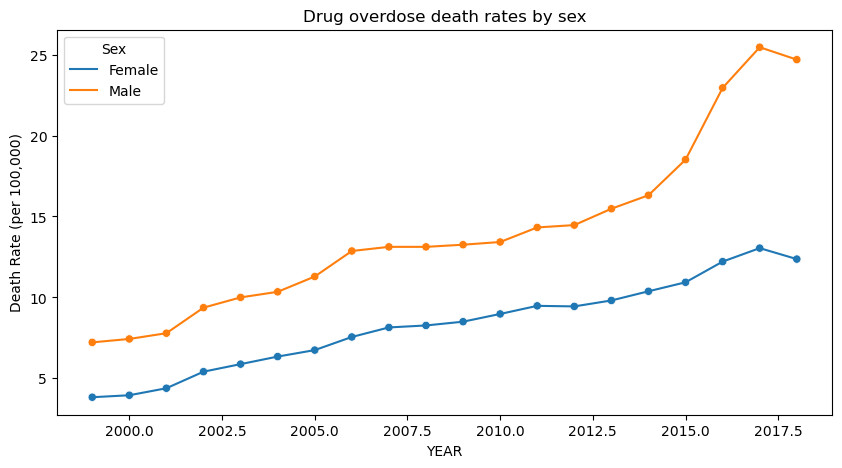

In [7]:
# plot year vs estimated deaths for each sex

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = male_female_ave, x='YEAR', y='ESTIMATE', hue='sex')
sns.lineplot(data = male_female_ave, x='YEAR', y='ESTIMATE', hue='sex')
# Add a legend and show the plot
ax.set_ylabel('Death Rate (per 100,000)')

# Get the current handles and labels
handles, labels = ax.get_legend_handles_labels()

# Create a dictionary to store unique labels and handles, which automatically removes duplicates
# Using dict.fromkeys preserves the insertion order in Python 3.7+
unique_labels_handles = dict(zip(labels, handles))

# Extract the unique handles and labels
unique_handles = unique_labels_handles.values()
unique_labels = unique_labels_handles.keys()

# Apply the unique handles and labels to the legend
ax.legend(unique_handles, unique_labels, title='Sex')


ax.set_title('Drug overdose death rates by sex')

fig.savefig('../figures/drug_overdose_death_rates_by_sex.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figures/drug_overdose_death_rates_by_sex.png")


✓ Saved: figures/drug_overdose_death_rates_by_age_group.png


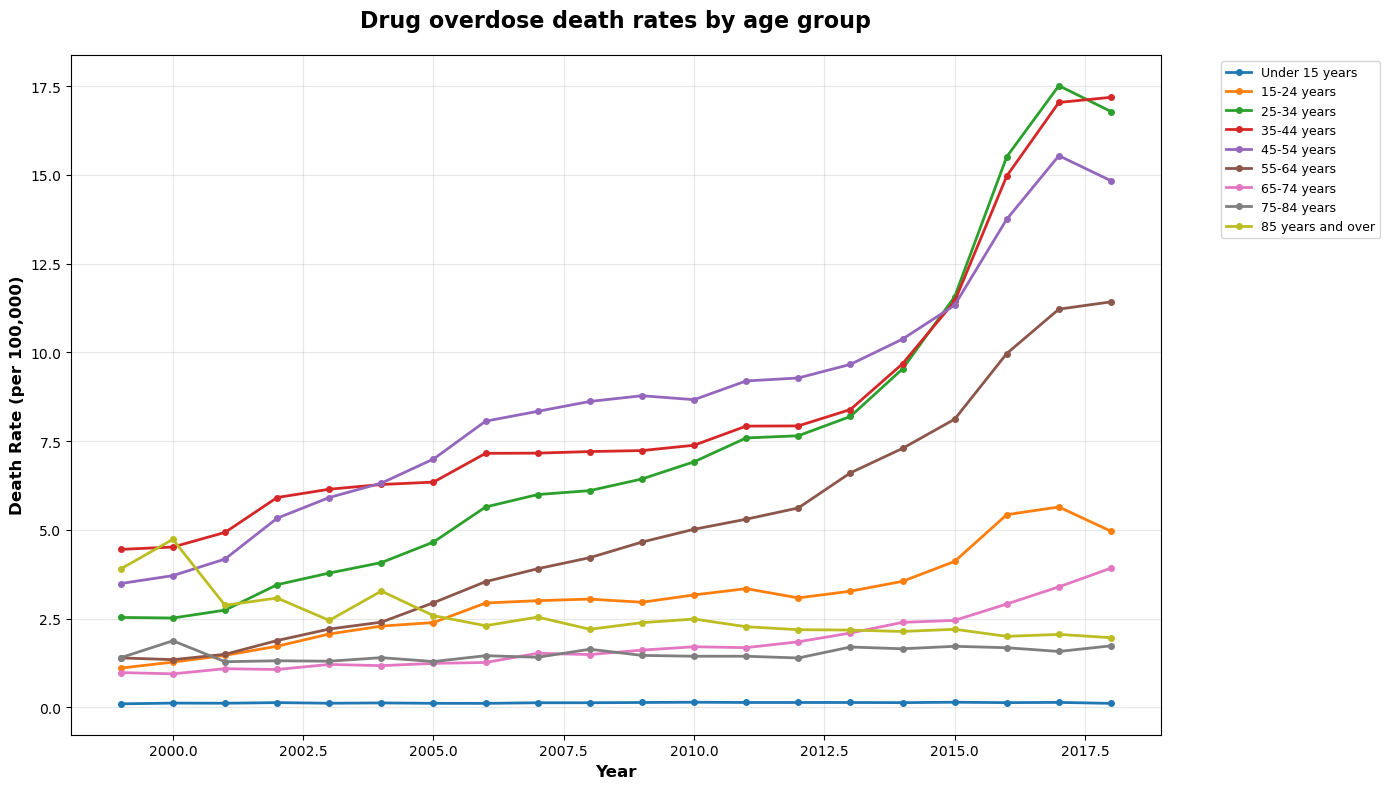

In [8]:
# filter data by age-group 
#Trend by Age group

plt.figure(figsize=(14, 8))

df_od_age_group_distinct = df_od_age_group[df_od_age_group["age_group"] != "All"]
age_groups = df_od_age_group_distinct['age_group'].unique()

for age_grp in age_groups:
    age_trend = df_od_age_group_distinct[
        (df_od_age_group_distinct['age_group'] == age_grp)].groupby('YEAR')['ESTIMATE'].mean().reset_index()

    if len(age_trend) > 0:
        plt.plot(age_trend['YEAR'], age_trend['ESTIMATE'],
                 marker='o', linewidth=2, label=age_grp, markersize=4)

plt.title('Drug overdose death rates by age group', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Death Rate (per 100,000)', fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('../figures/drug_overdose_death_rates_by_age_group.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figures/drug_overdose_death_rates_by_age_group.png")


In [9]:
# heatmap of rates by age x year
# create heatmap_data for distinct age_groups, not "All", and for sex not "All"
heatmap_data = all_od_deaths[(all_od_deaths["age_group"] != "All") & (all_od_deaths["sex"] != "All")]

heatmap_df = heatmap_data[['YEAR', 'sex', 'age_group', 'ESTIMATE']]
heatmap_grouped = heatmap_df.groupby(['YEAR', 'sex', 'age_group']).mean("ESTIMATE").reset_index() 
heatmap_grouped

,YEAR,sex,age_group,ESTIMATE
0,1999,Female,15-24 years,1.8
1,1999,Female,25-34 years,4.6
2,1999,Female,35-44 years,8.7
3,1999,Female,45-54 years,7.2
4,1999,Female,55-64 years,3.5
...,...,...,...,...
355,2018,Male,55-64 years,37.2
356,2018,Male,65-74 years,13.9
357,2018,Male,75-84 years,4.5
358,2018,Male,85 years and over,4.0


✓ Saved: figures/heatmap_by_age_group.png


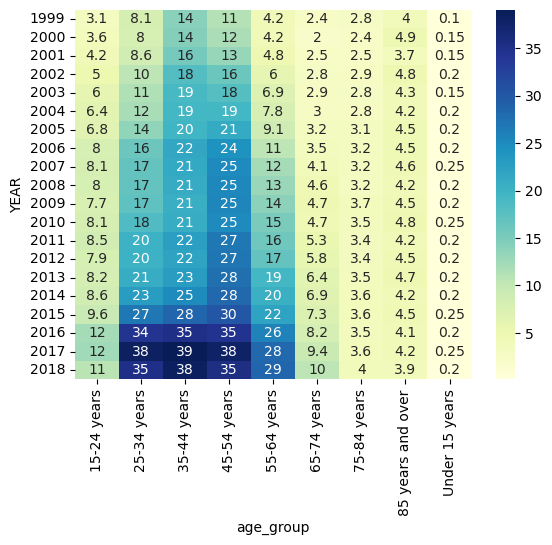

In [10]:
# Pivot the data into a matrix format (months as rows, years as columns)
heatmap_matrix = heatmap_grouped.pivot_table(index="YEAR", columns="age_group", values="ESTIMATE")
ax = sns.heatmap(heatmap_matrix, annot=True, cmap="YlGnBu")

# Get the Figure object and save it
fig = ax.get_figure()

fig.savefig('../figures/heatmap_by_age_group.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figures/heatmap_by_age_group.png")


✓ Saved: figures/heatmap_by_sex.png


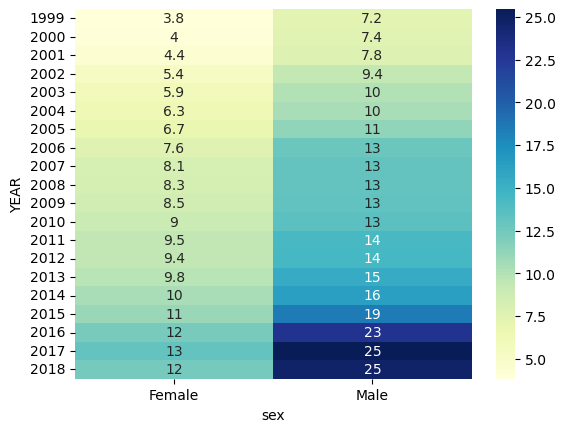

In [11]:
# Pivot the data into a matrix format (months as rows, years as columns)
heatmap_matrix = heatmap_grouped.pivot_table(index="YEAR", columns="sex", values="ESTIMATE")
ax = sns.heatmap(heatmap_matrix, annot=True, cmap="YlGnBu")

# Get the Figure object and save it
fig = ax.get_figure()

fig.savefig('../figures/heatmap_by_sex.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figures/heatmap_by_sex.png")

In [12]:
# compute rate of change
heatmap_data_m = heatmap_data[heatmap_data["sex"] == "Male"]
df_age_rate_of_change_m = utils.compute_rate_change(heatmap_data_m, 1999, 2018, group_col="age_group")
df_age_rate_of_change_m

,age_group,start_rate,end_rate,absolute_change,percent_change
0,Under 15 years,0.1,0.2,0.1,100.000000
1,15-24 years,4.5,14.3,9.8,217.777778
2,25-34 years,11.5,49.6,38.1,331.304348
3,35-44 years,19.2,52.4,33.2,172.916667
4,45-54 years,15.2,46.1,30.9,203.289474
5,55-64 years,4.9,37.2,32.3,659.183673
6,65-74 years,2.7,13.9,11.2,414.814815
7,75-84 years,2.5,4.5,2.0,80.000000
8,85 years and over,4.4,4.0,-0.4,-9.090909


In [13]:
# compute rate of change
heatmap_data_f = heatmap_data[heatmap_data["sex"] == "Female"]
df_age_rate_of_change_f = utils.compute_rate_change(heatmap_data_f, 1999, 2018, group_col="age_group")
df_age_rate_of_change_f

,age_group,start_rate,end_rate,absolute_change,percent_change
0,Under 15 years,0.1,0.2,0.1,100.000000
1,15-24 years,1.8,7.1,5.3,294.444444
2,25-34 years,4.6,20.8,16.2,352.173913
3,35-44 years,8.7,24.2,15.5,178.160920
4,45-54 years,7.2,24.8,17.6,244.444444
5,55-64 years,3.5,19.9,16.4,468.571429
6,65-74 years,2.1,7.1,5.0,238.095238
7,75-84 years,3.0,3.5,0.5,16.666667
8,85 years and over,3.5,3.7,0.2,5.714286


✓ Saved: figures/drug_overdose_deaths_percent_change_by_sex.png


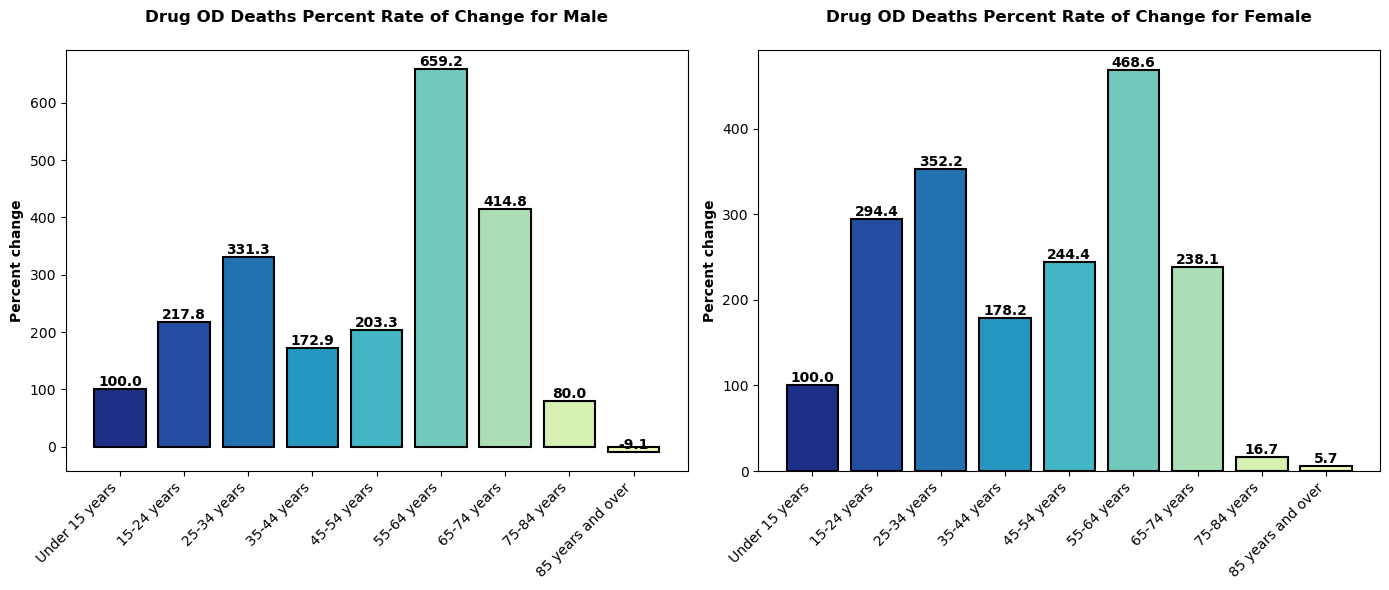

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

attr_name = 'percent_change'
attr_label = 'Percent change'
title_label = 'Drug OD Deaths Percent Rate of Change for '

dataset = df_age_rate_of_change_m
sex_label = "Male"

if len(dataset) > 0:
    n_colors = len(dataset)
    colors = sns.color_palette("YlGnBu_r", n_colors)
    bars = ax1.bar(dataset['age_group'], dataset[attr_name], 
                   color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xticks(range(len(dataset)), dataset['age_group'], 
               rotation=45, ha='right', fontsize=10)

    ax1.set_title(title_label+sex_label,
              fontsize=12, fontweight='bold', pad=20)
    ax1.set_ylabel(attr_label,
               fontsize=10, fontweight='bold')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=10,
                 fontweight='bold')

dataset = df_age_rate_of_change_f
sex_label = "Female"

if len(dataset) > 0:

    n_colors = len(dataset)
    colors = sns.color_palette("YlGnBu_r", n_colors)
    bars = ax2.bar(dataset['age_group'], dataset[attr_name], 
                   color=colors, edgecolor='black', linewidth=1.5)
    ax2.set_xticks(range(len(dataset)), dataset['age_group'], 
               rotation=45, ha='right', fontsize=10)

    ax2.set_title(title_label+sex_label,
              fontsize=12, fontweight='bold', pad=20)
    ax2.set_ylabel(attr_label,
               fontsize=10, fontweight='bold')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=10,
                 fontweight='bold')

plt.tight_layout()
# Display the plots

fig.savefig('../figures/drug_overdose_deaths_percent_change_by_sex.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figures/drug_overdose_deaths_percent_change_by_sex.png")


✓ Saved: figures/drug_overdose_deaths_absolute_change_by_sex.png


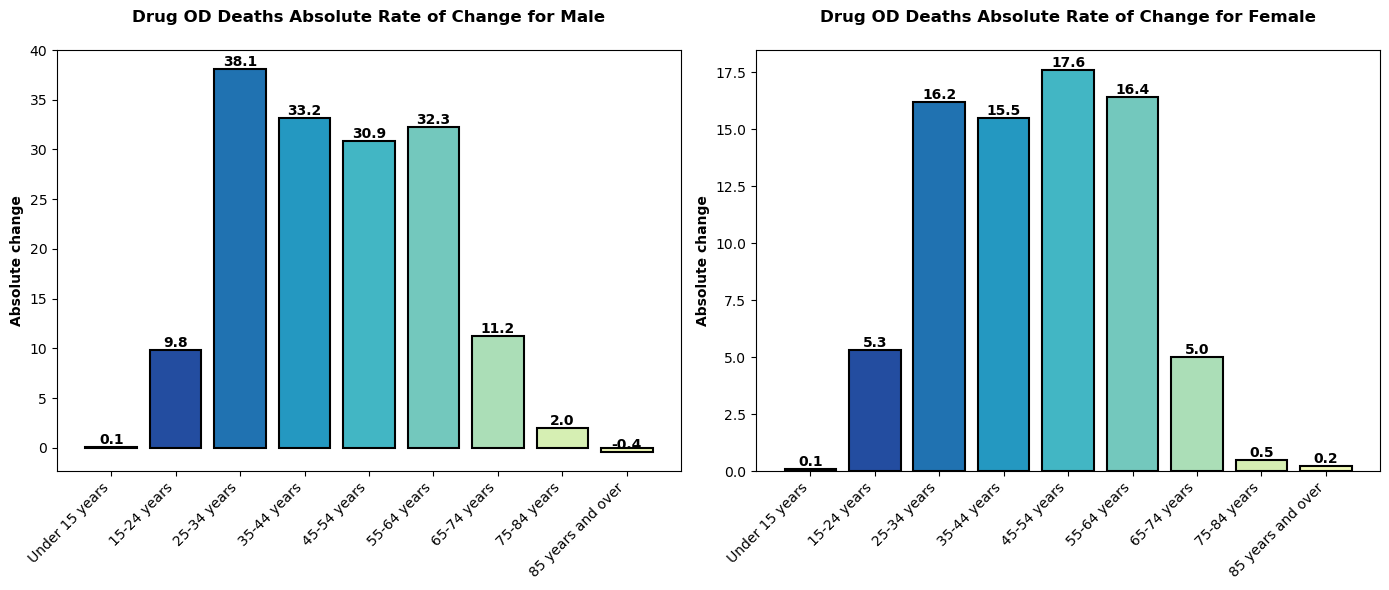

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

attr_name = 'absolute_change'
attr_label = 'Absolute change'
title_label = 'Drug OD Deaths Absolute Rate of Change for '

dataset = df_age_rate_of_change_m
sex_label = "Male"

if len(dataset) > 0:
    n_colors = len(dataset)
    colors = sns.color_palette("YlGnBu_r", n_colors)
    bars = ax1.bar(dataset['age_group'], dataset[attr_name], 
                   color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xticks(range(len(dataset)), dataset['age_group'], 
               rotation=45, ha='right', fontsize=10)

    ax1.set_title(title_label+sex_label,
              fontsize=12, fontweight='bold', pad=20)
    ax1.set_ylabel(attr_label,
               fontsize=10, fontweight='bold')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=10,
                 fontweight='bold')

dataset = df_age_rate_of_change_f
sex_label = "Female"

if len(dataset) > 0:

    n_colors = len(dataset)
    colors = sns.color_palette("YlGnBu_r", n_colors)
    bars = ax2.bar(dataset['age_group'], dataset[attr_name], 
                   color=colors, edgecolor='black', linewidth=1.5)
    ax2.set_xticks(range(len(dataset)), dataset['age_group'], 
               rotation=45, ha='right', fontsize=10)

    ax2.set_title(title_label+sex_label,
              fontsize=12, fontweight='bold', pad=20)
    ax2.set_ylabel(attr_label,
               fontsize=10, fontweight='bold')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=10,
                 fontweight='bold')

plt.tight_layout()

fig.savefig('../figures/drug_overdose_deaths_absolute_change_by_sex.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figures/drug_overdose_deaths_absolute_change_by_sex.png")


In [16]:
# Male groups with largest percent change
attr_name = 'percent_change'
dataset = df_age_rate_of_change_m
threshold = 200

dataset_sorted = dataset.sort_values(by = attr_name, ascending=False)
dataset_sorted_subset = dataset_sorted[dataset_sorted[attr_name] > threshold]
dataset_sorted_subset = dataset_sorted_subset[["age_group", attr_name]]
print(f"Top age groups for males experiencing the greater than {threshold} percent change:")
dataset_sorted_subset.head(10)

Top age groups for males experiencing the greater than 200 percent change:


,age_group,percent_change
5,55-64 years,659.183673
6,65-74 years,414.814815
2,25-34 years,331.304348
1,15-24 years,217.777778
4,45-54 years,203.289474


In [17]:
# Male groups with largest change
attr_name = 'absolute_change'
dataset = df_age_rate_of_change_m
threshold = 10

dataset_sorted = dataset.sort_values(by = attr_name, ascending=False)
dataset_sorted_subset = dataset_sorted[dataset_sorted[attr_name] > threshold]
dataset_sorted_subset = dataset_sorted_subset[["age_group", attr_name]]
print("Top age groups for males experiencing the largest absolute change:")
dataset_sorted_subset.head(10)

Top age groups for males experiencing the largest absolute change:


,age_group,absolute_change
2,25-34 years,38.1
3,35-44 years,33.2
5,55-64 years,32.3
4,45-54 years,30.9
6,65-74 years,11.2


In [18]:
# Female groups with largest change
attr_name = 'percent_change'
dataset = df_age_rate_of_change_f
threshold = 200

dataset_sorted = dataset.sort_values(by = attr_name, ascending=False)
dataset_sorted_subset = dataset_sorted[dataset_sorted[attr_name] > threshold]
dataset_sorted_subset = dataset_sorted_subset[["age_group", attr_name]]
print(f"Top age groups for females experiencing the greater than {threshold} percent change:")
dataset_sorted_subset.head(10)

Top age groups for females experiencing the greater than 200 percent change:


,age_group,percent_change
5,55-64 years,468.571429
2,25-34 years,352.173913
1,15-24 years,294.444444
4,45-54 years,244.444444
6,65-74 years,238.095238


In [19]:
# Female groups with largest change
attr_name = 'absolute_change'
dataset = df_age_rate_of_change_f
threshold = 10

dataset_sorted = dataset.sort_values(by = attr_name, ascending=False)
dataset_sorted_subset = dataset_sorted[dataset_sorted[attr_name] > threshold]
dataset_sorted_subset = dataset_sorted_subset[["age_group", attr_name]]
print("Top age groups for females experiencing the largest absolute change:")
dataset_sorted_subset.head(10)

Top age groups for females experiencing the largest absolute change:


,age_group,absolute_change
4,45-54 years,17.6
5,55-64 years,16.4
2,25-34 years,16.2
3,35-44 years,15.5
